# Two Line Elements Propagation

## Authors
Petrus Hyvönen, SSC

## Learning Goals
* *Propagate an TLE*: Specify and read a TLE and propagate it with the orekit TLE propagator
* *Representation of ground station*: How to represent ground points
* *Elementary plotting in Python*: Simple ways to plot data

## Keywords
orekit, TLE, ground station

## Summary

This small tutorial is a first step to a real propagation of a satellite orbit
based on the common TLE format. The results are propagated in an inertial coordinate
system and then converted to a topocentric coordinate system, such as a ground station.


# Set up 

In [1]:
%matplotlib inline

## Initialize Orekit 

Import orekit and set up the java virtual machine.

In [2]:
import orekit_jpype
vm = orekit_jpype.initVM()

Read the orekit-data file with basic paramters. This file is assumed to be in the current directory.

In [3]:
from orekit_jpype.pyhelpers import setup_orekit_data
setup_orekit_data()

Now we are set up to import and use objects from the orekit library.

In [4]:
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator

In [ ]:
from math import radians, pi
import matplotlib.pyplot as plt
import plotly.express as px


## Setting up the TLE 

Specify the two line elements that describes the orbit of the satellite as strings. Here these are specified directly, in a larger example these would likely be fetched from a file or from an on-line service.

In [6]:
#SPOT-5 
tle_line1 = "1 27421U 02021A   02124.48976499 -.00021470  00000-0 -89879-2 0    20"
tle_line2 = "2 27421  98.7490 199.5121 0001333 133.9522 226.1918 14.26113993    62"

The orekit TLE object parses the two line strings. [See TLE Doc](https://www.orekit.org/static/apidocs/org/orekit/propagation/analytical/tle/TLE.html) The Epoch is the timestamp where the two line elements are referenced to.

In [7]:
mytle = TLE(tle_line1,tle_line2)

print (mytle)
print ('Epoch :',mytle.getDate())

1 27421U 02021A   02124.48976499 -.00021470  00000-0 -89879-2 0    20
2 27421  98.7490 199.5121 0001333 133.9522 226.1918 14.26113993    62
Epoch : 2002-05-04T11:45:15.695136Z


## Preparing the Coordinate systems 

Orekit supports several coordinate systems, for this example the International Terrestrial Reference Frame (ITRF) is used for the planet. A slightly elliptical body is created for the Earth shape, according to the WGS84 model.

In [8]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

## Define the station

The location of the station is defined, and a [TopocentricFrame](https://www.orekit.org/site-orekit-10.1/apidocs/org/orekit/frames/TopocentricFrame.html) specific for this location is created.

This frame is based on a position near the surface of a body shape. The origin of the frame is at the defining geodetic point location, and the right-handed canonical trihedra is:

- X axis in the local horizontal plane (normal to zenith direction) and following the local parallel towards East
- Y axis in the horizontal plane (normal to zenith direction) and following the local meridian towards North
- Z axis towards Zenith direction

In [9]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station = GeodeticPoint(latitude, longitude, altitude)
station_frame = TopocentricFrame(earth, station, "Esrange")

For the propagation a Earth centered inertial coordinate system is used, the EME2000. This frame is commonly also called J2000. This is a commonly used frame centered at the Earth, and fixed towards reference stars (not rotating with the Earth).

In [10]:
inertialFrame = FramesFactory.getEME2000()

In [11]:
propagator = TLEPropagator.selectExtrapolator(mytle)

Set the start and end date that is then used for the propagation.

In [12]:
extrapDate = AbsoluteDate(2002, 5, 7, 12, 0, 0.0, TimeScalesFactory.getUTC())
finalDate = extrapDate.shiftedBy(60.0*60*24) #seconds

In [13]:
el=[]
pos=[]

This is the core loop that performs the propagation, stepping extrapDate through the range with set stepsize. The results are stored in the el and pos lists.

In [14]:
while (extrapDate.compareTo(finalDate) <= 0.0):  
    pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
    pos_tmp = pv.getPosition()
    pos.append((pos_tmp.getX(),pos_tmp.getY(),pos_tmp.getZ()))
    
    el_tmp = station_frame.getElevation(pv.getPosition(),
                    inertialFrame,
                    extrapDate)*180.0/pi
    el.append(el_tmp)
    #print extrapDate, pos_tmp, vel_tmp
    extrapDate = extrapDate.shiftedBy(10.0)

## Plot Results

Plot some of the results from the propagation. Note that in the plots below the x-axis are samples and not proper time.

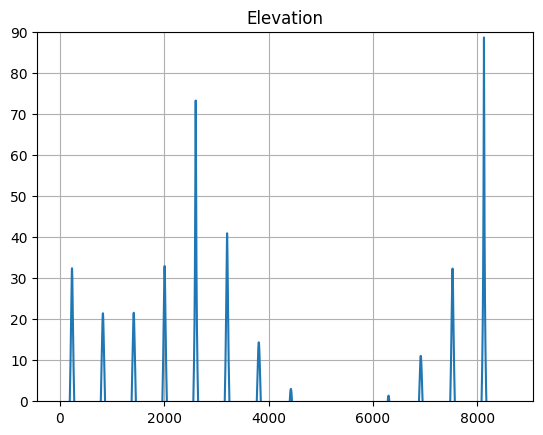

In [15]:
plt.plot(el)
plt.ylim(0,90)
plt.title('Elevation')
plt.grid(True)

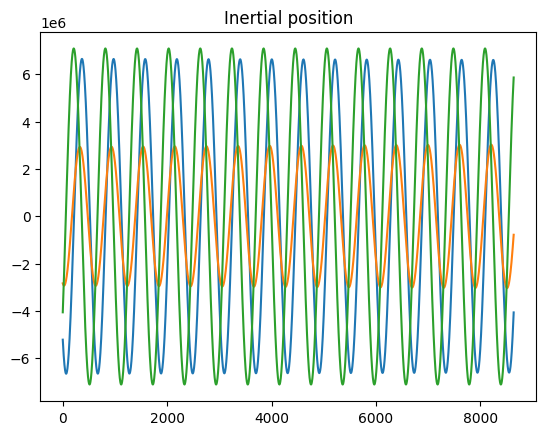

In [16]:
plt.plot(pos); 
plt.title('Inertial position');

## Exercise

Evaluate the maximum elevation of the International Space Station from your current location and for the coming 5 days, and at what time and date it occurs. The Two-Line Elements needs to be fresh, and fetched from internet. One site that is publishing recent elements is [Celestrack](https://www.celestrak.com/NORAD/elements/). Verify that the used TLE is fresh using the epoch.